# Поиск изображения по запросу

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

    
Нам необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

<b>Описание данны</b>

**1.** В файле `train_dataset.csv` находится информация, необходимая для обучения:
* имя файла изображения
* идентификатор описания и текст описания.

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

**2.** В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

**3.** В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

    1. Имя файла изображения.
    2. Идентификатор описания.

    3, 4, 5 — оценки трёх экспертов.

    Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 —  запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст    соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

**4.** В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

**5.** В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
import sys
print(sys.version)


3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [2]:
# # Install spaCy (run in terminal/prompt)
# import sys
# !{sys.executable} -m pip install spacy
# # Download spaCy's  'en' Model
# !{sys.executable} -m spacy download en

In [3]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install spacy[transformers]
# !pip install torchvision

In [4]:
# !pip install -U skorch

In [5]:
# !pip -q install sentence-transformers

In [6]:
import pandas as pd
import numpy as np
import re
import time
import statistics as st
import math
import random


from tqdm import tqdm
from tqdm import notebook

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

import transformers
from transformers import BertTokenizer, BertModel, BertConfig
# import os

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

import spacy


import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet#, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor

import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.corpus import stopwords as nltk_stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import catboost
from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import sentence_transformers
from sentence_transformers import SentenceTransformer, util

C:\Users\Katya\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Error loading punkt: <urlopen error [WinError 10060]
[nltk_data]     Попытка установить соединение была безуспешной, т.к.
[nltk_data]     от другого компьютера за требуемое время не получен
[nltk_data]     нужный отклик, или было разорвано уже установленное
[n

Импортируем данные и напишем функцию для просмотра информации о датафреймах.

In [7]:
def load_data(path):
    try:
        train_dataset = pd.read_csv(path+'train_dataset.csv')
        CrowdAnnotations = pd.read_csv(path+'CrowdAnnotations.tsv',
                                       sep='\t', header=None, names=['image', 'query_id', 'pos_share', 'pos_num_confirmed', 'neg_num_confirmed'])
        ExpertAnnotations = pd.read_csv(path+'ExpertAnnotations.tsv',
                                        sep='\t', header=None, names=['image', 'query_id', 'ex_1', 'ex_2', 'ex_3'])
        test_queries = pd.read_csv(path+'test_queries.csv', sep='|', index_col=0)
        test_images = pd.read_csv(path+'test_images.csv', sep='|')
        
    except FileNotFoundError:
        print('Произошла ошибка')
    
    return train_dataset, CrowdAnnotations, ExpertAnnotations, test_queries, test_images

In [8]:
path = 'dsplus_integrated_project_4/to_upload/'

In [9]:
train_dataset, CrowdAnnotations, ExpertAnnotations, test_queries, test_images = load_data(path)

Напишем функцию, которая выведет необходимую информацию о датафреймах.

In [10]:
def describe_dataframe(df_title):
    print(df_title)
    df = globals()[df_title]
    display(df.head())
    df.info()
    df.describe()
    print('\n')

In [11]:
for df_title in ['train_dataset', 'CrowdAnnotations', 'ExpertAnnotations', 'test_queries', 'test_images']:
    describe_dataframe(df_title)

train_dataset


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


CrowdAnnotations


image                     query_id  pos_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   pos_num_confirmed  neg_num_confirmed  
0                  3                  0  
1                  0                  3  
2                  0                  3  
3                  0                  3  
4                  0                  3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image              47830 non-null  object 
 1   query_id           47830 non-null  object 
 2   pos_share          47830 non-null  float64
 3   pos_num_confirmed  47830 non-null  int64  
 4   neg_num_confirmed  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


ExpertAnnotations


image                     query_id  ex_1  ex_2  ex_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   ex_1      5822 non-null   int64 
 3   ex_2      5822 non-null   int64 
 4   ex_3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


test_queries


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


test_images


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes




Посмотрим подробнее информацию о train_dataset. В признаке "query_id" содержится идентификатор описания в формате <имя файла изображения>#<порядковый номер описания>. К каждой картинке может быть до 5 описаний. Но кажется, что все записи в датасете содержат только порядковый номер 2. Проверим.

In [12]:
train_dataset['query_id'].apply(lambda x: x[x.find('#'):]).unique()

array(['#2'], dtype=object)

In [13]:
train_dataset.groupby('query_id')['query_text'].nunique().unique()

array([1], dtype=int64)

Действительно так. Казалось бы стоит удалить порядковый номер, но мы не будем этого делать, так как вероятнее всего в датасете представлена только часть данных. А вот в test_queries содержаться запросы с разными номерами. Поэтому не будем удалять номер запроса.

При этом каждому query_id соответсвует только один query_text.

In [14]:
len(train_dataset['query_id'].unique())

977

In [15]:
len(train_dataset['query_text'].unique())

977

In [16]:
len(train_dataset['image'].unique())

1000

In [17]:
train_dataset.iloc[0]['image']

'1056338697_4f7d7ce270.jpg'

Обучающая выборка содержит 977 уникальных описаний и 1000 уникальных изображений.

Посмотрим несколько изображений

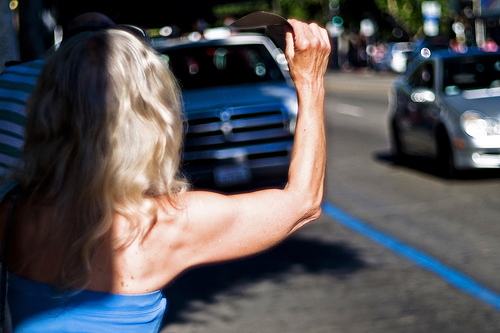

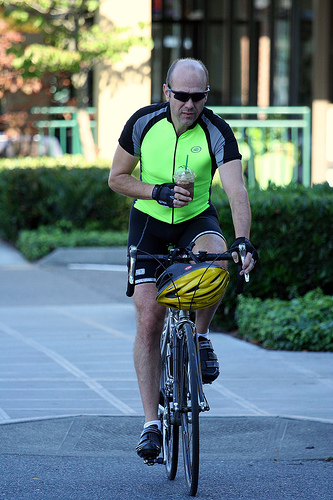

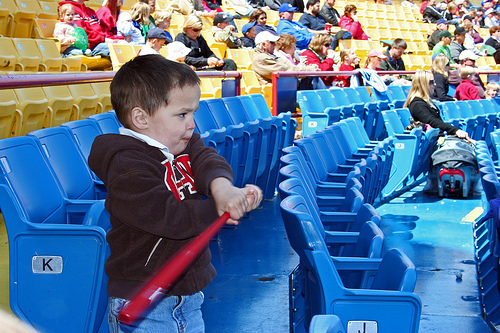

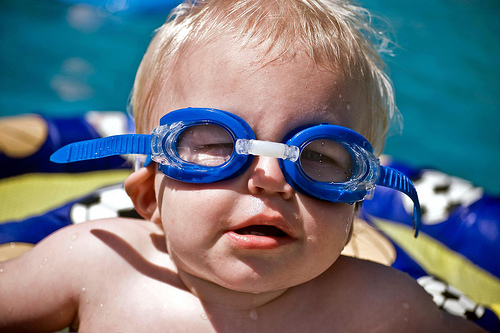

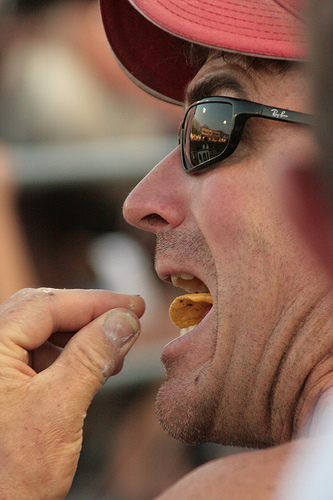

In [18]:
for i in range(0, 5):
    image_name = train_dataset.iloc[i]['image']
    img = Image.open(path+"train_images/"+image_name).convert('RGB') 
    display(img)

**Вывод**

В нашем основном датасете около 5800 строк. Пропусков в данных нет. В признаке "query_id" содержится идентификатор описания в формате <имя файла изображения>#<порядковый номер описания>. Заявлено, что к каждой картинке может быть до 5 описаний. Но все записи в датасете содержат только порядковый номер 2. Вероятнее всего в датасете представлена только часть данных. А вот в test_queries содержаться запросы с разными номерами. Поэтому мы не удалили номер запроса.

Обучающая выборка содержит 977 уникальных описаний и 1000 уникальных изображений.

В CrowdAnnotations содержится 47830 строк. Пропусков также нет. Столбец pos_share содержит информацию о доле людей, которые отметили пару картинка-описание как подходящие друг другу. Но стоит отметить, что в отличие от экспертов, обычные люди могли ставить только 1 или 0. Тогда как эксперты могли выставлять оценку соответствия по шкале от 1 до 4. Можно сказать, что разметка данных от экспертов более качественная. Возможно стоит использовать именно её для лучшего обучения модели. Также при объединении датафреймов CrowdAnnotations и ExpertAnnotations теряется очень много данных, в том числе с экспертной оценкой.

Выборка содердит разные по формату и тематике изображения людей и животных.

## Предобработка и объединение датафреймов

Для решения задачи нам необходимо выделить целевой признак. В нешем случае это степень соответствия описания и изображения. У нас есть две талицы с такой информацией: `CrowdAnnotations` и `ExpertAnnotations`.

Определимся как мы составим финальную оценку - таргет.

В `CrowdAnnotations` содержится 47830 строк. Пропусков нет. Столбец pos_share содержит информацию о доле людей, которые отметили пару картинка-описание как подходящие друг другу. Но стоит отметить, что в отличие от экспертов, обычные люди могли ставить только 1 или 0. Тогда как эксперты в `ExpertAnnotations` могли выставлять оценку соответствия по шкале от 1 до 4. Можно сказать, что разметка данных от экспертов более качественная. 

Кажется, что в `CrowdAnnotations` много данных, однако при объединении с train_dataset мы теряем порядка 60% строк. Так как в `CrowdAnnotations` нет многих сочетаний картинка - описание из `train_dataset`, в котором содержится текст запроса. А соединение с сохранением всех строк `train_dataset` не имеет смысла, так как мы не получаем целевой признак для 60% строк.

Напротив, при объединении с `ExpertAnnotations` мы теряем ни одной строки и получаем более качественную разметку данных.

Объединим эти два датафрейма.

### Объединение датафреймов

In [19]:
display(train_dataset.head())
train_dataset.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [20]:
display(ExpertAnnotations.head())
ExpertAnnotations.info()

image                     query_id  ex_1  ex_2  ex_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   ex_1      5822 non-null   int64 
 3   ex_2      5822 non-null   int64 
 4   ex_3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [21]:
data_train = ExpertAnnotations.merge(train_dataset, on=['image', 'query_id'])
display(data_train.head(10))
data_train.info()

image                     query_id  ex_1  ex_2  ex_3  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2     1     1     1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2     1     1     1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2     1     1     2   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2     1     1     1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2     2     2     2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .  
5  A soccer ball is above the head of a man weari...  
6  A young boy dressed in a red uniform kicks the...  
7  A man and woman look back at the camera while ...  
8  A white dog jumps to catch a blue ball in a li...  
9       A little boy shakes the snow off of a tree .

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   ex_1        5822 non-null   int64 
 3   ex_2        5822 non-null   int64 
 4   ex_3        5822 non-null   int64 
 5   query_text  5822 non-null   object
dtypes: int64(3), object(3)
memory usage: 273.0+ KB


**Вывод**

Для решения задачи нам необходимо было выделить целевой признак. В нешем случае это степень соответствия описания и изображения. У нас есть две талицы с такой информацией: `CrowdAnnotations` и `ExpertAnnotations`.

В `CrowdAnnotations` содержится 47830 строк. Пропусков нет. Столбец pos_share содержит информацию о доле людей, которые отметили пару картинка-описание как подходящие друг другу. Но стоит отметить, что в отличие от экспертов, обычные люди могли ставить только 1 или 0. Тогда как эксперты в `ExpertAnnotations` могли выставлять оценку соответствия по шкале от 1 до 4. Можно сказать, что разметка данных от экспертов более качественная. 

Кажется, что в `CrowdAnnotations` много данных, однако при объединении с train_dataset мы теряем порядка 60% строк. Так как в `CrowdAnnotations` нет многих сочетаний картинка - описание из `train_dataset`, в котором содержится текст запроса. А соединение с сохранением всех строк `train_dataset` не имеет смысла, так как мы не получаем целевой признак для 60% строк.

Напротив, при объединении с `ExpertAnnotations` мы теряем ни одной строки и получаем более качественную разметку данных.

Мы объединили `ExpertAnnotations` и `train_dataset` не потеряв ни одной строки и получив достаточно качественную оценку от экспертов.

### Оценка экспертов

Поработаем над нашим целевым признаком.

Для начала объединим три оценки экспертов в одну. Поскольку в таблице есть оценки от трёх экспертов, напишем функцию, которая обобщает оценку: выбирает наиболее частую оценку (моду), а если такой нет нет, то возвращает None.

Удалим строки, для которых не получили единой оценки.

Потом нормализуем полученную оценку. Модель должна выдавать результат от 0 до 1. Эксперты давали 4 оценки от 1 до 4, где 1 полное несоответсвие, а 4 полное соответсвие. Переведём это в доли, где 1 - 0, а 4 - 1 по формуле (x-1)/3.

In [23]:
def expert_opinion(x):
    m = int(st.mode(x))
    res = 0
    for i in x:
        if m == i:
            res+=1
    if res == 1:
        m = None
    return m

In [24]:
data_train['target'] = data_train[['ex_1', 'ex_2', 'ex_3']].apply(lambda x: expert_opinion(x), axis=1)
data_train[15:20]

image                     query_id  ex_1  ex_2  ex_3  \
15   106490881_5a2dd9b7bd.jpg   493621130_152bdd4e91.jpg#2     1     1     1   
16  1082379191_ec1e53f996.jpg  1287475186_2dee85f1a5.jpg#2     1     1     1   
17  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2     1     2     3   
18  1082379191_ec1e53f996.jpg  2472980433_210ec62874.jpg#2     1     1     2   
19  1082379191_ec1e53f996.jpg  2893374123_087f98d58a.jpg#2     1     1     2   

                                           query_text  target  
15   A dog wearing a collar jumping from a platform .     1.0  
16     A young boy in a swimming suit sits in water .     1.0  
17              A crowd of people at an outdoor event     NaN  
18  A man riding a motorcycle is performing a tric...     1.0  
19  A man riding a blue motorcycle jumps over a ra...     1.0

Удалим строки, для которых не получили единой оценки.

In [25]:
shape_old = data_train.shape[0]

data_train = data_train.dropna()

shape_new = data_train.shape[0]
print('Количество строк до:', shape_old, '\n',
      'Количество строк после:', shape_new, '\n',
      'Процент потерь:', round((shape_old - shape_new) / shape_old * 100, 2), '%')

Количество строк до: 5822 
 Количество строк после: 5696 
 Процент потерь: 2.16 %


Мы потеряли 2.16 % строк. Это допустимо.

Теперь нормализуем полученную оценку. Модель должна выдавать результат от 0 до 1. Эксперты давали 4 оценки от 1 до 4, где 1 полное несоответсвие, а 4 полное соответсвие. Переведём это в доли, где 1 - 0, а 4 - 1 по формуле (x-1)/3.

In [26]:
data_train['target'] = (data_train['target'] - 1) / 3
data_train.head()

image                     query_id  ex_1  ex_2  ex_3  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A girl wearing a yellow shirt and sunglasses s...  0.000000  
2    A man sleeps under a blanket on a city street .  0.000000  
3  A woman plays with long red ribbons in an empt...  0.333333  
4         Chinese market street in the winter time .  0.000000

**Вывод**

Мы получили наш целевой признак target

Объединим три оценки экспертов в одну. Поскольку в таблице есть оценки от трёх экспертов, написали функцию, которая обощила оценку: выбрала наиболее частую оценку (моду), а если такой нет нет, то вернула None.

Улаоиои строки, для которых не получили единой оценки. Потеряли 2.16 % строк, что допустимо.

Нормализовали полученную оценку. Модель должна выдавать результат от 0 до 1. Эксперты давали 4 оценки от 1 до 4, где 1 полное несоответсвие, а 4 полное соответсвие. Мы перевели это в доли, где 1 - 0, а 4 - 1 по формуле (x-1)/3.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Очистим данные от фото с детьми. Составим словарь с запрещёнными словами. Напишем функцию, которая проверяет описания и возвращает True если текст соответвует юридически м ограничениям, и False если не соответсвует.

Для проверки текст стоило бы лемматизировать текст, однако это достаточно долгая и затратная обработка данных. Поэтому для очистки данных от запрещённых слов просто добавим в словарь разные формы запрещенных слов. А для векторизации текстов воспользуемся предобученной моделью BERT, которая работает и с не лематизированным текстом.

In [27]:
exc_dic = ['baby',
           'boy',
           'child',
           'girl',
           'teenager',
           'schoolboy',
           'youth',
           'newborn', 
           'kid',
           'toddler',
           'babys',
           'boys',
           'children',
           'girls',
           'teenagers',
           'schoolboys',
           'newborns', 
           'kids',
           'toddlers']
exc_dic.sort()
exc_dic

['baby',
 'babys',
 'boy',
 'boys',
 'child',
 'children',
 'girl',
 'girls',
 'kid',
 'kids',
 'newborn',
 'newborns',
 'schoolboy',
 'schoolboys',
 'teenager',
 'teenagers',
 'toddler',
 'toddlers',
 'youth']

In [28]:
def find_exc_word(text):
    for word in exc_dic:
        if text.lower().find(word) != -1:
            return False
    return True

In [29]:
%%time
data_train['is_available'] = data_train['query_text'].apply(find_exc_word)

CPU times: total: 15.6 ms
Wall time: 26 ms


In [30]:
data_train[20:25]

image                     query_id  ex_1  ex_2  ex_3  \
21  1084040636_97d9633581.jpg  2544426580_317b1f1f73.jpg#2     1     1     1   
22  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2     2     3     3   
23  1084040636_97d9633581.jpg  3385593926_d3e9c21170.jpg#2     1     2     2   
24  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2     1     2     2   
25  1084040636_97d9633581.jpg   542179694_e170e9e465.jpg#2     1     1     2   

                                         query_text    target  is_available  
21           The baby in suspenders sits by a toy .  0.000000         False  
22     Close-up of dog in profile with mouth open .  0.666667          True  
23     Two brown dogs playfully fight in the snow .  0.333333          True  
24                     A dog gets on a trampoline .  0.333333          True  
25  A jogger with a dog approaches a ladder truck .  0.000000          True

составим список запрещённых изображений.

In [32]:
forbiden_img = list(data_train[data_train['is_available']==False]
                    ['query_id'].apply(lambda x: x[:x.find('#')]).unique())
forbiden_img[:3]

['2549968784_39bfbe44f9.jpg',
 '2718495608_d8533e3ac5.jpg',
 '3545652636_0746537307.jpg']

In [33]:
len(forbiden_img)

294

Мы нашли 296 неподходящих фото. Уберём их из обучающей выборки.

In [34]:
shape_old = train_dataset.shape[0]

data_train = data_train.query('image not in @forbiden_img')

shape_new = data_train.shape[0]
print('Количество строк до:', shape_old, '\n',
      'Количество строк после:', shape_new, '\n',
      'Процент потерь:', round((shape_old - shape_new) / shape_old * 100, 2), '%')

Количество строк до: 5822 
 Количество строк после: 3978 
 Процент потерь: 31.67 %


**Вывод**

Поскольку в некоторых странах действуют ограничения по обработке изображений, нам необходимо было исключить из датафрема все описания детей в возрасте до 16 лет. Мы составили составили словарь с запрещёнными словами. Написали функцию, которая проверяет описания и возвращает True если текст соответвует юридическим ограничениям, и False если не соответсвует.

Для проверки стоило бы лемматизировать текст, однако это достаточно долгая и затратная обработка данных. Поэтому для очистки данных от запрещённых слов мы просто добавили в словарь разные формы запрещенных слов. А для векторизации текстов воспользуемся предобученной моделью BERT, которая работает и с не лематизированным текстом.

Мы составили список запрещённых фото, описание которых содержит запрещенные слова. Таких фото оказалось 296. Мы удалили их из датафрейма потеряв 31.67 % строк.

## 3. Векторизация изображений



Для векторизации изображений используем предобученную resnet18. Уберем последний слой, чтобы получить на выходе вектор. На примере одного из изображений посмотрим, какой вектор получается.

In [35]:
resnet = models.resnet18(pretrained=True)

In [36]:
for param in resnet.parameters():
    ### замораживаем веса
    param.requires_grad_(False)

In [37]:
### берём все слои кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval();

In [38]:
### переводим изображение в нужный формат: меняем размер картинки, ырезаем центр и нормализуем
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]
                            )
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 norm,
                                ]
                                )

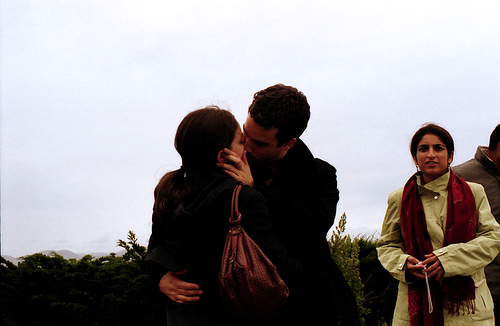

In [39]:
image_name = data_train.sample(1).iloc[0]['image']
img = Image.open(path+"train_images/"+image_name).convert('RGB') 
img

In [40]:
image_tensor = preprocess(img)
output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
output_tensor.size()

torch.Size([512])

Поличили вектор размерностью 512.

Напишем функцию для векторизации изображений

In [41]:
### Напишем функцию для векторизации изображений
def vectorize_img(data, path):
    image_vec = []
    img_names = pd.DataFrame(data.image.unique(), columns=['image'])
    for image in tqdm(img_names['image']):
        img = Image.open(path+image).convert('RGB')
        image_tensor = preprocess(img)
        output_tensor = resnet(image_tensor.unsqueeze(0)).flatten().numpy()
        image_vec.append(output_tensor)
    print(f'Размер вектора изображений: {np.array(image_vec).shape}')

    df_unique_img = pd.concat([img_names, pd.DataFrame(image_vec)], axis= 1)
    df_unique_img.columns = ['img_' + str(column) if isinstance(column, int) 
                             else str(column) for column in df_unique_img.columns]    
    return df_unique_img

In [42]:
df_unique_img = vectorize_img(data_train, path+'train_images/')

100%|████████████████████████████████████████████████████████████████████████████████| 706/706 [00:27<00:00, 25.72it/s]


Размер вектора изображений: (706, 512)


In [43]:
df_unique_img.head()

image     img_0     img_1     img_2     img_3  \
0  1056338697_4f7d7ce270.jpg  0.693981  3.031816  2.916986  0.951921   
1  1082379191_ec1e53f996.jpg  0.580882  0.636027  1.235305  1.239307   
2  1084040636_97d9633581.jpg  0.891785  0.699768  0.743491  0.213386   
3  1107246521_d16a476380.jpg  1.173782  1.277593  1.220057  0.511006   
4  1119015538_e8e796281e.jpg  0.868181  0.421632  0.035825  0.204046   

      img_4     img_5     img_6     img_7     img_8  ...   img_502   img_503  \
0  0.936226  1.245219  0.826550  1.108058  0.169696  ...  0.444238  0.717754   
1  1.264694  0.385739  0.521414  1.737713  0.354155  ...  0.707460  0.972236   
2  1.508289  1.159896  1.463326  3.576004  0.260950  ...  1.121152  0.670595   
3  1.628965  0.791934  0.256380  0.031555  0.556466  ...  0.672687  0.696745   
4  0.285495  0.197902  0.847773  0.728671  1.442089  ...  0.510151  0.548297   

    img_504   img_505   img_506   img_507   img_508   img_509   img_510  \
0  0.294678  0.728789  1.153812  0.750846  1.196695  0.085011  1.056858   
1  0.291919  1.237114  0.270918  0.241003  0.039484  0.229986  2.469594   
2  0.416134  2.027011  0.029152  0.080594  1.536912  0.533676  1.394792   
3  0.368280  1.062172  0.204912  0.822552  0.092431  1.479730  0.760468   
4  0.028085  0.964417  1.442034  0.544693  0.352939  1.391845  0.590310   

    img_511  
0  0.098236  
1  0.110243  
2  0.070406  
3  0.132308  
4  0.168133  

[5 rows x 513 columns]

**Вывод**
Используя предобученную resnet18 мы получили вектора для каждого уникального изображения из обучающего датасета.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Получим вектора текстов при помощи BERT. Также создадим датафрейм с уникальными описаниями.

In [44]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

In [45]:
model_bert=BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [46]:
len(data_train['query_text'].unique())

940

У нас есть 940 уникальное описание

In [47]:
### Напишем функцию для векторизации описаний
def vectorize_txt(data, tokenizer, model, batch_size=1):
    
    df = pd.DataFrame(data['query_text'].unique(), columns=['query_text'])

    ### токенизируем все уникальные тексты запросов
    tokenized = df['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    
    ### считаем максимальную длину токенизированного описания
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    print(f'Максимальная длина вектора текста: {max_len}')
    
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    
    text_vec = []    
    for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        text_vec.append(batch_embeddings[0][:,0,:].numpy())

    features = np.concatenate(text_vec)
    
    print(f'Размер вектора изображений: {np.array(features).shape}')
    
    df_unique_txt = pd.concat([df, pd.DataFrame(features)], axis=1)

    df_unique_txt.columns = ['txt_' + str(column) if isinstance(column, int) 
                             else str(column) for column in df_unique_txt.columns]    
    return df_unique_txt

# .squeeze(0)

In [48]:
%%time
df_unique_txt = vectorize_txt(data_train, tokenizer, model_bert, batch_size=1)

Максимальная длина вектора текста: 36


100%|████████████████████████████████████████████████████████████████████████████████| 940/940 [01:44<00:00,  8.96it/s]

Размер вектора изображений: (940, 768)
CPU times: total: 13min 56s
Wall time: 1min 45s


In [49]:
df_unique_txt.head()

query_text     txt_0     txt_1  \
0  A young child is wearing blue goggles and sitt... -0.047877  0.051415   
1  A girl wearing a yellow shirt and sunglasses s...  0.306461  0.187396   
2    A man sleeps under a blanket on a city street .  0.225946 -0.147770   
3  A woman plays with long red ribbons in an empt...  0.363719  0.163009   
4         Chinese market street in the winter time . -0.368424 -0.235774   

      txt_2     txt_3     txt_4     txt_5     txt_6     txt_7     txt_8  ...  \
0 -0.272813 -0.072299  0.047598 -0.743571  0.045497  0.837148 -0.502959  ...   
1 -0.317479 -0.147754  0.092267 -0.241827  0.248197  0.775116 -0.397221  ...   
2 -0.410427  0.009857  0.024526 -0.012760 -0.160295  1.200930 -0.407790  ...   
3 -0.490554  0.019928  0.072832 -0.125191 -0.251206  0.910355 -0.630080  ...   
4 -0.305801  0.175350  0.182788 -0.072999  0.053588  1.238183 -0.730164  ...   

    txt_758   txt_759   txt_760   txt_761   txt_762   txt_763   txt_764  \
0 -0.365719 -0.110821 -0.342743 -0.105674 -0.026857  0.914323  0.184041   
1 -0.326402  0.434386 -0.106929  0.084437 -0.069695  0.619139  0.204060   
2 -0.113069 -0.112948 -0.309222 -0.056992  0.130479  0.988332 -0.092634   
3 -0.033179  0.282282 -0.214147  0.347063  0.388013  0.896650  0.471117   
4  0.186065 -0.355032 -0.142532  0.475379  0.240221 -0.005224 -0.248849   

    txt_765   txt_766   txt_767  
0  0.020952  0.323602  0.604958  
1 -0.192757  0.181120  0.577594  
2 -0.319207  0.430009  0.243055  
3 -0.301245  0.148654  0.346313  
4 -0.535117  0.498606  0.076596  

[5 rows x 769 columns]

**Вывод**

При помощи предобученной модели BERT мы получили вектора уникальных описаний и сохранили их в датафрейм df_unique_txt.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [50]:
display(df_unique_img.head())
df_unique_img.info()

image     img_0     img_1     img_2     img_3  \
0  1056338697_4f7d7ce270.jpg  0.693981  3.031816  2.916986  0.951921   
1  1082379191_ec1e53f996.jpg  0.580882  0.636027  1.235305  1.239307   
2  1084040636_97d9633581.jpg  0.891785  0.699768  0.743491  0.213386   
3  1107246521_d16a476380.jpg  1.173782  1.277593  1.220057  0.511006   
4  1119015538_e8e796281e.jpg  0.868181  0.421632  0.035825  0.204046   

      img_4     img_5     img_6     img_7     img_8  ...   img_502   img_503  \
0  0.936226  1.245219  0.826550  1.108058  0.169696  ...  0.444238  0.717754   
1  1.264694  0.385739  0.521414  1.737713  0.354155  ...  0.707460  0.972236   
2  1.508289  1.159896  1.463326  3.576004  0.260950  ...  1.121152  0.670595   
3  1.628965  0.791934  0.256380  0.031555  0.556466  ...  0.672687  0.696745   
4  0.285495  0.197902  0.847773  0.728671  1.442089  ...  0.510151  0.548297   

    img_504   img_505   img_506   img_507   img_508   img_509   img_510  \
0  0.294678  0.728789  1.153812  0.750846  1.196695  0.085011  1.056858   
1  0.291919  1.237114  0.270918  0.241003  0.039484  0.229986  2.469594   
2  0.416134  2.027011  0.029152  0.080594  1.536912  0.533676  1.394792   
3  0.368280  1.062172  0.204912  0.822552  0.092431  1.479730  0.760468   
4  0.028085  0.964417  1.442034  0.544693  0.352939  1.391845  0.590310   

    img_511  
0  0.098236  
1  0.110243  
2  0.070406  
3  0.132308  
4  0.168133  

[5 rows x 513 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Columns: 513 entries, image to img_511
dtypes: float32(512), object(1)
memory usage: 1.4+ MB


In [51]:
display(df_unique_txt.head())
df_unique_txt.info()

query_text     txt_0     txt_1  \
0  A young child is wearing blue goggles and sitt... -0.047877  0.051415   
1  A girl wearing a yellow shirt and sunglasses s...  0.306461  0.187396   
2    A man sleeps under a blanket on a city street .  0.225946 -0.147770   
3  A woman plays with long red ribbons in an empt...  0.363719  0.163009   
4         Chinese market street in the winter time . -0.368424 -0.235774   

      txt_2     txt_3     txt_4     txt_5     txt_6     txt_7     txt_8  ...  \
0 -0.272813 -0.072299  0.047598 -0.743571  0.045497  0.837148 -0.502959  ...   
1 -0.317479 -0.147754  0.092267 -0.241827  0.248197  0.775116 -0.397221  ...   
2 -0.410427  0.009857  0.024526 -0.012760 -0.160295  1.200930 -0.407790  ...   
3 -0.490554  0.019928  0.072832 -0.125191 -0.251206  0.910355 -0.630080  ...   
4 -0.305801  0.175350  0.182788 -0.072999  0.053588  1.238183 -0.730164  ...   

    txt_758   txt_759   txt_760   txt_761   txt_762   txt_763   txt_764  \
0 -0.365719 -0.110821 -0.342743 -0.105674 -0.026857  0.914323  0.184041   
1 -0.326402  0.434386 -0.106929  0.084437 -0.069695  0.619139  0.204060   
2 -0.113069 -0.112948 -0.309222 -0.056992  0.130479  0.988332 -0.092634   
3 -0.033179  0.282282 -0.214147  0.347063  0.388013  0.896650  0.471117   
4  0.186065 -0.355032 -0.142532  0.475379  0.240221 -0.005224 -0.248849   

    txt_765   txt_766   txt_767  
0  0.020952  0.323602  0.604958  
1 -0.192757  0.181120  0.577594  
2 -0.319207  0.430009  0.243055  
3 -0.301245  0.148654  0.346313  
4 -0.535117  0.498606  0.076596  

[5 rows x 769 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Columns: 769 entries, query_text to txt_767
dtypes: float32(768), object(1)
memory usage: 2.8+ MB


In [52]:
df = data_train[['image', 'query_id', 'query_text', 'target']]
display(df.head())
df.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A girl wearing a yellow shirt and sunglasses s...  0.000000  
2    A man sleeps under a blanket on a city street .  0.000000  
3  A woman plays with long red ribbons in an empt...  0.333333  
4         Chinese market street in the winter time .  0.000000

<class 'pandas.core.frame.DataFrame'>
Index: 3978 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       3978 non-null   object 
 1   query_id    3978 non-null   object 
 2   query_text  3978 non-null   object 
 3   target      3978 non-null   float64
dtypes: float64(1), object(3)
memory usage: 155.4+ KB


In [53]:
df_final = ((df.merge(df_unique_img, on='image', how='left'))
              .merge(df_unique_txt, on='query_text', how='left', suffixes=(False, False)))

In [54]:
df_final.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text    target     img_0  \
0  A young child is wearing blue goggles and sitt...  0.000000  0.693981   
1  A girl wearing a yellow shirt and sunglasses s...  0.000000  0.693981   
2    A man sleeps under a blanket on a city street .  0.000000  0.693981   
3  A woman plays with long red ribbons in an empt...  0.333333  0.693981   
4         Chinese market street in the winter time .  0.000000  0.693981   

      img_1     img_2     img_3     img_4     img_5  ...   txt_758   txt_759  \
0  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.365719 -0.110821   
1  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.326402  0.434386   
2  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.113069 -0.112948   
3  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.033179  0.282282   
4  3.031816  2.916986  0.951921  0.936226  1.245219  ...  0.186065 -0.355032   

    txt_760   txt_761   txt_762   txt_763   txt_764   txt_765   txt_766  \
0 -0.342743 -0.105674 -0.026857  0.914323  0.184041  0.020952  0.323602   
1 -0.106929  0.084437 -0.069695  0.619139  0.204060 -0.192757  0.181120   
2 -0.309222 -0.056992  0.130479  0.988332 -0.092634 -0.319207  0.430009   
3 -0.214147  0.347063  0.388013  0.896650  0.471117 -0.301245  0.148654   
4 -0.142532  0.475379  0.240221 -0.005224 -0.248849 -0.535117  0.498606   

    txt_767  
0  0.604958  
1  0.577594  
2  0.243055  
3  0.346313  
4  0.076596  

[5 rows x 1284 columns]

In [55]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3978 entries, 0 to 3977
Columns: 1284 entries, image to txt_767
dtypes: float32(1280), float64(1), object(3)
memory usage: 19.5+ MB


**Вывод**

Мы присоединили к нашему очищенному датафрейму с экспертной оценкой уникальные векторы соответсвующего изображения и описания. Размер полученного датафрейма 3978 строк × 1284 признаков.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [56]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=df_final.drop(columns=['target']),
                                             y=df_final['target'], groups=data_train['image']))

In [57]:
train_df, valid_df = df_final.loc[train_indices], df_final.loc[valid_indices]

In [58]:
train_df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
...                         ...                          ...   
3973   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2   
3974   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2   
3975   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2   
3976   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2   
3977   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2   

                                             query_text    target     img_0  \
0     A young child is wearing blue goggles and sitt...  0.000000  0.693981   
1     A girl wearing a yellow shirt and sunglasses s...  0.000000  0.693981   
2       A man sleeps under a blanket on a city street .  0.000000  0.693981   
3     A woman plays with long red ribbons in an empt...  0.333333  0.693981   
4            Chinese market street in the winter time .  0.000000  0.693981   
...                                                 ...       ...       ...   
3973  People trackside at a subway station by a train .  0.000000  1.836281   
3974                        A man sitting on a subway .  0.000000  1.836281   
3975  A man wearing a red hat looks down as another ...  0.000000  1.836281   
3976         A white birds lands swiftly in the water .  0.000000  1.836281   
3977       A person wearing a white hat climbs a rock .  0.666667  1.836281   

         img_1     img_2     img_3     img_4     img_5  ...   txt_758  \
0     3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.365719   
1     3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.326402   
2     3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.113069   
3     3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.033179   
4     3.031816  2.916986  0.951921  0.936226  1.245219  ...  0.186065   
...        ...       ...       ...       ...       ...  ...       ...   
3973  0.537826  0.549317  1.469246  0.357578  1.096264  ... -0.125857   
3974  0.537826  0.549317  1.469246  0.357578  1.096264  ...  0.133189   
3975  0.537826  0.549317  1.469246  0.357578  1.096264  ... -0.399359   
3976  0.537826  0.549317  1.469246  0.357578  1.096264  ... -0.021943   
3977  0.537826  0.549317  1.469246  0.357578  1.096264  ... -0.213497   

       txt_759   txt_760   txt_761   txt_762   txt_763   txt_764   txt_765  \
0    -0.110821 -0.342743 -0.105674 -0.026857  0.914323  0.184041  0.020952   
1     0.434386 -0.106929  0.084437 -0.069695  0.619139  0.204060 -0.192757   
2    -0.112948 -0.309222 -0.056992  0.130479  0.988332 -0.092634 -0.319207   
3     0.282282 -0.214147  0.347063  0.388013  0.896650  0.471117 -0.301245   
4    -0.355032 -0.142532  0.475379  0.240221 -0.005224 -0.248849 -0.535117   
...        ...       ...       ...       ...       ...       ...       ...   
3973 -0.273825  0.076364 -0.206110  0.356360  0.791323 -0.069625 -0.459691   
3974 -0.268332 -0.198130 -0.138998 -0.018723  0.130610 -0.727078 -0.319372   
3975  0.059859 -0.333742  0.067204 -0.150735  0.402575  0.168506 -0.277717   
3976  0.437145 -0.145553  0.308121  0.146656  0.289277  0.089929 -0.164149   
3977 -0.375805  0.185101 -0.256894  0.386479  0.700431  0.507243 -0.134223   

       txt_766   txt_767  
0     0.323602  0.604958  
1     0.181120  0.577594  
2     0.430009  0.243055  
3     0.148654  0.346313  
4     0.498606  0.076596  
...        ...       ...  
3973  0.293383  0.187597  
3974  0.270727  0.277035  
3975  0.268213  0.632979  
3976  0.121327  0.429065  
3977  0.146014  0.250715  

[2768 rows x 1284 columns]

In [59]:
display(train_df.head())
train_df.shape
train_df.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text    target     img_0  \
0  A young child is wearing blue goggles and sitt...  0.000000  0.693981   
1  A girl wearing a yellow shirt and sunglasses s...  0.000000  0.693981   
2    A man sleeps under a blanket on a city street .  0.000000  0.693981   
3  A woman plays with long red ribbons in an empt...  0.333333  0.693981   
4         Chinese market street in the winter time .  0.000000  0.693981   

      img_1     img_2     img_3     img_4     img_5  ...   txt_758   txt_759  \
0  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.365719 -0.110821   
1  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.326402  0.434386   
2  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.113069 -0.112948   
3  3.031816  2.916986  0.951921  0.936226  1.245219  ... -0.033179  0.282282   
4  3.031816  2.916986  0.951921  0.936226  1.245219  ...  0.186065 -0.355032   

    txt_760   txt_761   txt_762   txt_763   txt_764   txt_765   txt_766  \
0 -0.342743 -0.105674 -0.026857  0.914323  0.184041  0.020952  0.323602   
1 -0.106929  0.084437 -0.069695  0.619139  0.204060 -0.192757  0.181120   
2 -0.309222 -0.056992  0.130479  0.988332 -0.092634 -0.319207  0.430009   
3 -0.214147  0.347063  0.388013  0.896650  0.471117 -0.301245  0.148654   
4 -0.142532  0.475379  0.240221 -0.005224 -0.248849 -0.535117  0.498606   

    txt_767  
0  0.604958  
1  0.577594  
2  0.243055  
3  0.346313  
4  0.076596  

[5 rows x 1284 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 2768 entries, 0 to 3977
Columns: 1284 entries, image to txt_767
dtypes: float32(1280), float64(1), object(3)
memory usage: 13.6+ MB


In [60]:
display(valid_df.head())
valid_df.shape
valid_df.info()

image                     query_id  \
11  1084040636_97d9633581.jpg  2358554995_54ed3baa83.jpg#2   
12  1084040636_97d9633581.jpg  2544426580_317b1f1f73.jpg#2   
13  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2   
14  1084040636_97d9633581.jpg  3385593926_d3e9c21170.jpg#2   
15  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2   

                                           query_text    target     img_0  \
11  A child is preparing to slide down a piece of ...  0.000000  0.891785   
12             The baby in suspenders sits by a toy .  0.000000  0.891785   
13       Close-up of dog in profile with mouth open .  0.666667  0.891785   
14       Two brown dogs playfully fight in the snow .  0.333333  0.891785   
15                       A dog gets on a trampoline .  0.333333  0.891785   

       img_1     img_2     img_3     img_4     img_5  ...   txt_758   txt_759  \
11  0.699768  0.743491  0.213386  1.508289  1.159896  ... -0.326312  0.132980   
12  0.699768  0.743491  0.213386  1.508289  1.159896  ... -0.130862  0.224965   
13  0.699768  0.743491  0.213386  1.508289  1.159896  ...  0.388348 -0.084949   
14  0.699768  0.743491  0.213386  1.508289  1.159896  ... -0.456661 -0.172662   
15  0.699768  0.743491  0.213386  1.508289  1.159896  ...  0.055243 -0.256805   

     txt_760   txt_761   txt_762   txt_763   txt_764   txt_765   txt_766  \
11 -0.336794  0.022642 -0.104637  0.994976  0.390233 -0.018969  0.006176   
12 -0.099769  0.124170  0.353519  0.371804  0.070877 -0.256224  0.422821   
13 -0.279822 -0.423207 -0.034709  0.364053 -0.082785 -0.283853  0.092392   
14 -0.081230 -0.058891  0.253703  0.836402  0.291781 -0.268874  0.506191   
15  0.152937 -0.110882  0.236138  0.915993  0.296063 -0.499622 -0.036508   

     txt_767  
11  0.117668  
12  0.161291  
13 -0.308583  
14  0.202550  
15  0.617519  

[5 rows x 1284 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 1210 entries, 11 to 3959
Columns: 1284 entries, image to txt_767
dtypes: float32(1280), float64(1), object(3)
memory usage: 6.0+ MB


In [61]:
features_train = train_df.drop(columns=['image', 'query_id', 'query_text', 'target'])
target_train = train_df['target']
features_valid = valid_df.drop(columns=['image', 'query_id', 'query_text', 'target'])
target_valid = valid_df['target']

### Baseline

Получим бэйзлайн для оценки адекватности моделей. Используем DummyRegressor для оценки среднего значения обучающего набора. В качестве метрики выберем MAE, она измеряет разницу между предсказанными значениями и истинными значениями.

In [62]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_train, target_train)
DummyRegressor()

DummyRegressor()

In [63]:
dummy_regr.score(features_train, target_train)

-0.5695125024500884

In [64]:
dummy_regr.predict(features_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
print("MAE dummy_regressor:", mean_absolute_error(target_train, dummy_regr.predict(features_train)))

MAE dummy_regressor: 0.22784200385356454


In [66]:
# Random = np.random.uniform(low=0, high=1, size=(len(target_valid.index)))
# zeros = np.zeros(shape=len(target_valid.index))

# df = pd.Series(Random, index=target_valid.index.to_list())
# df
# # df = pd.Series(zeros, index=target_valid.index.to_list())
# # df

# print("RMSE:", mean_squared_error(target_valid, df, squared=False))

# print("MAE:", mean_absolute_error(target_valid, df))

### Линейная регрессия

In [67]:
model_lr = LinearRegression(n_jobs=-1)
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_lr = GridSearchCV(model_lr,parameters, scoring='neg_mean_absolute_error')

In [68]:
%%time
grid_lr.fit(features_train, target_train)

CPU times: total: 48.7 s
Wall time: 6.16 s


GridSearchCV(estimator=LinearRegression(n_jobs=-1),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [69]:
grid_lr.best_params_

{'copy_X': True, 'fit_intercept': False}

In [70]:
grid_lr.best_estimator_

LinearRegression(fit_intercept=False, n_jobs=-1)

In [71]:
-grid_lr.best_score_ 

0.6938172812877589

In [72]:
LR_score = mean_absolute_error(target_valid, grid_lr.predict(features_valid))

In [73]:
print("MAE:", LR_score)

MAE: 0.8414566440643747


### LightGBM

In [74]:
%%time
model_lgbm = LGBMRegressor(random_state=1234, n_jobs=1)

params = { 'max_depth': range(9, 12, 2),
           'n_estimators': range(200, 301, 100),
            'min_data_in_leaf':[15, 25]}

CPU times: total: 0 ns
Wall time: 0 ns


In [75]:
%%time
grid_lgbm = GridSearchCV(model_lgbm, params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_lgbm.fit(features_train, target_train);

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 321304
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 1280
[LightGBM] [Info] Start training from score 0.227842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [76]:
grid_lgbm.best_estimator_

LGBMRegressor(max_depth=11, min_data_in_leaf=25, n_estimators=300, n_jobs=1,
              random_state=1234)

In [77]:
grid_lgbm.best_score_ 

-0.21224807544532748

In [78]:
lgbm_score = mean_absolute_error(target_valid, grid_lgbm.predict(features_valid))

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [79]:
print("MAE:", lgbm_score)

MAE: 0.20004648262368885


### ElasticNet

In [80]:
model_elastic = ElasticNet(random_state=12345)
params = {"max_iter": [1, 5, 10],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}
grid_elastic = GridSearchCV(model_elastic, params, scoring='neg_mean_absolute_error', n_jobs=-1)

In [81]:
%%time
grid_elastic.fit(features_train, target_train)

CPU times: total: 10.4 s
Wall time: 14.7 s


GridSearchCV(estimator=ElasticNet(random_state=12345), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             scoring='neg_mean_absolute_error')

In [82]:
grid_elastic.best_score_
grid_elastic.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.30000000000000004, max_iter=5,
           random_state=12345)

In [83]:
elastic_score =  mean_absolute_error(target_valid, grid_elastic.predict(features_valid))

In [84]:
print("MAE:", elastic_score)

MAE: 0.22393464609857433


### Catboost

In [85]:
%%time


model_cat = CatBoostRegressor(random_state = 12345, verbose=False)
params = {'iterations': [200, 600],
          'learning_rate': [0.03, 0.1],
            'depth': [1, 4, 6]
            }

grid_cat = GridSearchCV(estimator=model_cat, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_cat.fit(features_train, target_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 20.7 s
Wall time: 4min 9s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x00000230F22EC650>,
             n_jobs=-1,
             param_grid={'depth': [1, 4, 6], 'iterations': [200, 600],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_absolute_error')

In [86]:
print(grid_cat.best_params_)
print(grid_cat.best_score_)

{'depth': 1, 'iterations': 200, 'learning_rate': 0.1}
-0.22779308965269446


In [87]:
cat_score =  mean_absolute_error(target_valid, grid_cat.predict(features_valid))

In [88]:
print("MAE:", cat_score)

MAE: 0.22179413938025103


### Net

In [89]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = scaler.fit_transform(features_train)
X_valid = scaler.transform(features_valid)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(target_train.values)
X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(target_valid.values)

In [90]:
#Batch Normalization
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
#         self.act3 = nn.ReLU()
        self.act3 = nn.Sigmoid()
        
        self.flatten = nn.Flatten(start_dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return self.flatten(x)

In [91]:
def train_model(model, lr=0.001, num_epochs=10, verbose=10):
    net.train()

    optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=0.05)
    loss = nn.MSELoss()
    model = model

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()
        if epoch % verbose == 0 or epoch == num_epochs-1:
            mae_test = mean_absolute_error(net.forward(X_valid).detach().numpy(), y_valid)
            print(f'Эпоха {epoch}, MAE на тестовых данных', mae_test)

    return net.eval(), mae_test

In [92]:
n_in_neurons = X_train.size()[1]
n_hidden_neurons_1 = 3072
n_hidden_neurons_2 = 1024
n_hidden_neurons_3 = 768
n_hidden_neurons_4 = 256
n_hidden_neurons_5 = 64
n_out_neurons = 1

net = Net(n_in_neurons, 
          n_hidden_neurons_1, 
          n_hidden_neurons_2,
          n_out_neurons)

model, mae_test = train_model(net, num_epochs=1000, verbose=100, lr=0.005)

Эпоха 0, MAE на тестовых данных 0.35126528
Эпоха 100, MAE на тестовых данных 0.23512734
Эпоха 200, MAE на тестовых данных 0.22160952
Эпоха 300, MAE на тестовых данных 0.23868261
Эпоха 400, MAE на тестовых данных 0.25076288
Эпоха 500, MAE на тестовых данных 0.25859126
Эпоха 600, MAE на тестовых данных 0.2601427
Эпоха 700, MAE на тестовых данных 0.26014012
Эпоха 800, MAE на тестовых данных 0.26014003
Эпоха 900, MAE на тестовых данных 0.26014003
Эпоха 999, MAE на тестовых данных 0.26014003


### Итог

In [93]:
dt = pd.DataFrame({'model': ['LinearRegression', 'LightGBM', 'ElasticNet', 'Catboost', 'Net'],
                   'score': [LR_score, lgbm_score, elastic_score, cat_score, mae_test]})
dt

model     score
0  LinearRegression  0.841457
1          LightGBM  0.200046
2        ElasticNet  0.223935
3          Catboost  0.221794
4               Net  0.260140

**Вывод**

Мы получили бэйзлайн на базе DummyRegressor(strategy="median"). Можно использовать метрику бэйзлайна и метрики других моделей, для оценки их адекватности.

В качестве метрики выберем MAE, она измеряет разницу между предсказанными значениями и истинными значениями.

Также мы обучили модели линейной регрессии, LightGBM, ElasticNet, Catboost и нейронную сеть.

Лучшую метрику на валидационной выборке показала модель LightGBM. Опробуем её на тестовых запросах.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Векторизируем все изображения из тестового набора.

In [94]:
df_unique_img_test = vectorize_img(test_images, path+'test_images/')
df_unique_img_test

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.13it/s]


Размер вектора изображений: (100, 512)


image     img_0     img_1     img_2     img_3  \
0   3356748019_2251399314.jpg  0.669249  0.004512  0.236133  0.882863   
1   2887171449_f54a2b9f39.jpg  0.949642  3.252444  0.698425  1.281522   
2   3089107423_81a24eaf18.jpg  1.416902  0.973558  0.583846  0.330448   
3   1429546659_44cb09cbe2.jpg  0.189787  1.876468  0.825718  0.621149   
4   1177994172_10d143cb8d.jpg  0.443963  2.334486  0.006339  2.394353   
..                        ...       ...       ...       ...       ...   
95  2431120202_b24fe2333a.jpg  1.208322  0.739464  0.050839  0.083080   
96  2399219552_bbba0a9a59.jpg  1.183395  1.067557  1.575832  2.378845   
97  3091962081_194f2f3bd4.jpg  0.090710  1.954055  0.718825  0.601076   
98  2670637584_d96efb8afa.jpg  0.193626  0.848143  0.737124  0.553370   
99  2346402952_e47d0065b6.jpg  0.094777  0.438139  2.430755  0.666201   

       img_4     img_5     img_6     img_7     img_8  ...   img_502   img_503  \
0   1.709107  0.125581  1.020888  0.168621  1.178943  ...  0.297464  0.749478   
1   0.327045  0.496742  0.039870  0.161778  0.413211  ...  1.429109  0.314530   
2   2.646278  0.159476  1.165331  0.870155  0.707672  ...  0.628046  0.402085   
3   2.310625  0.565720  0.033543  0.556440  0.402366  ...  0.879860  0.729771   
4   0.022514  0.329740  1.683887  1.900140  0.215906  ...  0.141606  0.323036   
..       ...       ...       ...       ...       ...  ...       ...       ...   
95  0.920781  0.655538  0.497049  0.089066  1.798971  ...  0.376967  0.555691   
96  1.213923  0.715848  0.162706  1.838344  0.662807  ...  1.153936  0.926652   
97  0.089057  0.158459  1.597549  0.435845  0.418540  ...  0.136947  0.656670   
98  0.133546  0.554957  0.057235  1.707975  1.222223  ...  1.005810  0.988515   
99  0.313920  0.448235  0.630196  1.002802  1.046606  ...  0.012831  1.649578   

     img_504   img_505   img_506   img_507   img_508   img_509   img_510  \
0   2.343132  0.512026  1.853229  1.385057  0.171342  0.792277  0.206550   
1   1.680999  0.658177  2.667507  0.813781  1.553188  1.157070  1.100775   
2   0.314864  0.222127  0.883812  0.438337  1.542880  0.381310  0.060056   
3   0.114588  0.915989  0.860376  1.078615  0.487137  1.073111  0.847126   
4   1.905803  1.066337  0.000000  2.231437  2.022537  2.292717  0.793585   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.512230  0.740154  1.496848  0.393386  0.572447  0.359475  0.984353   
96  3.266215  1.928313  1.340950  1.124263  1.901592  0.053653  1.678620   
97  0.903572  0.796692  0.846823  0.718059  0.633133  1.676569  1.758489   
98  0.946502  0.568668  1.705837  0.122522  0.776738  0.539999  2.390810   
99  0.877142  0.746205  1.250985  0.561963  1.122451  0.608868  1.804157   

     img_511  
0   1.448476  
1   0.439246  
2   0.403146  
3   0.025273  
4   0.850107  
..       ...  
95  0.530105  
96  0.391140  
97  0.122395  
98  1.154147  
99  0.771301  

[100 rows x 513 columns]

In [95]:
df_unique_img_test

image     img_0     img_1     img_2     img_3  \
0   3356748019_2251399314.jpg  0.669249  0.004512  0.236133  0.882863   
1   2887171449_f54a2b9f39.jpg  0.949642  3.252444  0.698425  1.281522   
2   3089107423_81a24eaf18.jpg  1.416902  0.973558  0.583846  0.330448   
3   1429546659_44cb09cbe2.jpg  0.189787  1.876468  0.825718  0.621149   
4   1177994172_10d143cb8d.jpg  0.443963  2.334486  0.006339  2.394353   
..                        ...       ...       ...       ...       ...   
95  2431120202_b24fe2333a.jpg  1.208322  0.739464  0.050839  0.083080   
96  2399219552_bbba0a9a59.jpg  1.183395  1.067557  1.575832  2.378845   
97  3091962081_194f2f3bd4.jpg  0.090710  1.954055  0.718825  0.601076   
98  2670637584_d96efb8afa.jpg  0.193626  0.848143  0.737124  0.553370   
99  2346402952_e47d0065b6.jpg  0.094777  0.438139  2.430755  0.666201   

       img_4     img_5     img_6     img_7     img_8  ...   img_502   img_503  \
0   1.709107  0.125581  1.020888  0.168621  1.178943  ...  0.297464  0.749478   
1   0.327045  0.496742  0.039870  0.161778  0.413211  ...  1.429109  0.314530   
2   2.646278  0.159476  1.165331  0.870155  0.707672  ...  0.628046  0.402085   
3   2.310625  0.565720  0.033543  0.556440  0.402366  ...  0.879860  0.729771   
4   0.022514  0.329740  1.683887  1.900140  0.215906  ...  0.141606  0.323036   
..       ...       ...       ...       ...       ...  ...       ...       ...   
95  0.920781  0.655538  0.497049  0.089066  1.798971  ...  0.376967  0.555691   
96  1.213923  0.715848  0.162706  1.838344  0.662807  ...  1.153936  0.926652   
97  0.089057  0.158459  1.597549  0.435845  0.418540  ...  0.136947  0.656670   
98  0.133546  0.554957  0.057235  1.707975  1.222223  ...  1.005810  0.988515   
99  0.313920  0.448235  0.630196  1.002802  1.046606  ...  0.012831  1.649578   

     img_504   img_505   img_506   img_507   img_508   img_509   img_510  \
0   2.343132  0.512026  1.853229  1.385057  0.171342  0.792277  0.206550   
1   1.680999  0.658177  2.667507  0.813781  1.553188  1.157070  1.100775   
2   0.314864  0.222127  0.883812  0.438337  1.542880  0.381310  0.060056   
3   0.114588  0.915989  0.860376  1.078615  0.487137  1.073111  0.847126   
4   1.905803  1.066337  0.000000  2.231437  2.022537  2.292717  0.793585   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.512230  0.740154  1.496848  0.393386  0.572447  0.359475  0.984353   
96  3.266215  1.928313  1.340950  1.124263  1.901592  0.053653  1.678620   
97  0.903572  0.796692  0.846823  0.718059  0.633133  1.676569  1.758489   
98  0.946502  0.568668  1.705837  0.122522  0.776738  0.539999  2.390810   
99  0.877142  0.746205  1.250985  0.561963  1.122451  0.608868  1.804157   

     img_511  
0   1.448476  
1   0.439246  
2   0.403146  
3   0.025273  
4   0.850107  
..       ...  
95  0.530105  
96  0.391140  
97  0.122395  
98  1.154147  
99  0.771301  

[100 rows x 513 columns]

Получим несколько случайных запросов из тестового датасета.

In [96]:
df_sample = test_queries.sample(10)
df_sample

query_id  \
471   862156271_3eacea90a8.jpg#1   
472   862156271_3eacea90a8.jpg#2   
344  3455405300_aa3069ecaa.jpg#4   
170  2737233999_34d60dc5c3.jpg#0   
481   957682378_46c3b07bcd.jpg#1   
250  3163198309_bbfe504f0a.jpg#0   
454   607339469_af851c4119.jpg#4   
52   1991806812_065f747689.jpg#2   
259  3170110692_d1e0e66cee.jpg#4   
404  3601978895_9fec23ce0c.jpg#4   

                                            query_text  \
471                    two girls walking in the street   
472  Two girls walking next to each other and talki...   
344         Women wearing red and black are clapping .   
170                 Four children playing basketball .   
481  A brown dog is grabbing the collar of a black ...   
250  A skier coming over a snowy hill while people ...   
454                      Little girl feeds the ducks .   
52                      a kickboxer jumping for a kick   
259  A woman and a man pose with Groucho Marx disgu...   
404  Two men standing near a metal structure in fro...   

                         image  
471   862156271_3eacea90a8.jpg  
472   862156271_3eacea90a8.jpg  
344  3455405300_aa3069ecaa.jpg  
170  2737233999_34d60dc5c3.jpg  
481   957682378_46c3b07bcd.jpg  
250  3163198309_bbfe504f0a.jpg  
454   607339469_af851c4119.jpg  
52   1991806812_065f747689.jpg  
259  3170110692_d1e0e66cee.jpg  
404  3601978895_9fec23ce0c.jpg

Напишем функцию, которая получает на вход несколько запросов и подбирает подходящие изображения.

### Предсказания на lgbm

In [101]:
def search_img(df_sample):

    ###  текст запросов и проверим на запрещенные слова. И удалим эти строки.
    df_sample['is_available'] = df_sample['query_text'].apply(find_exc_word)
    
    
    for i in df_sample.index.to_list():
        if df_sample.loc[i]['is_available'] == False:
            print(df_sample.loc[i]['query_text'])
            print('Запрос содержит запрещенные слова. \n')
            df_sample = df_sample.drop(i)
            
    ### Векторизируем оставщиеся запросы.        
    df_unique_txt_test = vectorize_txt(df_sample, tokenizer, model_bert, batch_size=1)

    
    for i in range(0, df_sample.shape[0]):

        dd = df_unique_txt_test[i:i+1]
        df = pd.concat([dd]*len(df_unique_img_test), ignore_index=True)
        df.head()

        dff = pd.concat([df_unique_img_test, df], axis=1)

        features_test = dff.drop(columns=['image', 'query_text'])

        predictions_test = grid_lgbm.predict(features_test)

        dff['preds'] = pd.Series(predictions_test)
            

        print(df_sample.iloc[i]['query_text'])
        image_name = dff[dff['preds'] == dff['preds'].max()]['image'].to_list()[0]
        best_img = Image.open(path+"test_images/"+image_name).convert('RGB') 
        display(best_img)
        print(dff['preds'].max())

two girls walking in the street
Запрос содержит запрещенные слова. 

Two girls walking next to each other and talking .
Запрос содержит запрещенные слова. 

Four children playing basketball .
Запрос содержит запрещенные слова. 

Little girl feeds the ducks .
Запрос содержит запрещенные слова. 

Максимальная длина вектора текста: 16


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.22it/s]


Размер вектора изображений: (6, 768)
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Women wearing red and black are clapping .


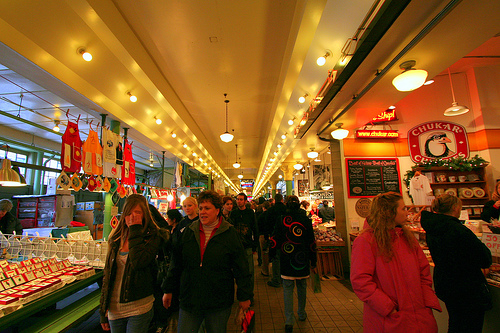

0.32940645554729614
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
A brown dog is grabbing the collar of a black dog .


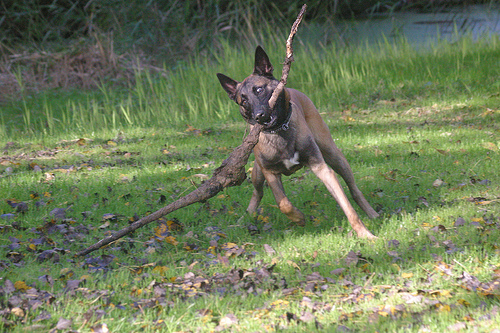

0.5585893671893597
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
A skier coming over a snowy hill while people look on .


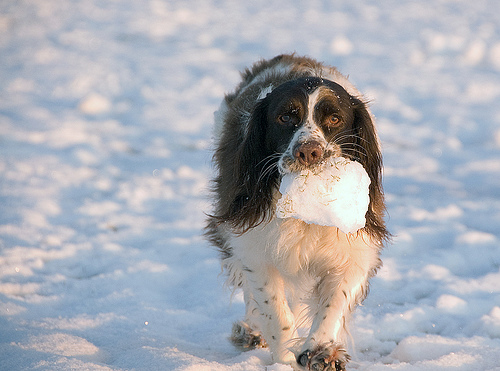

0.5209504893657894
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
a kickboxer jumping for a kick


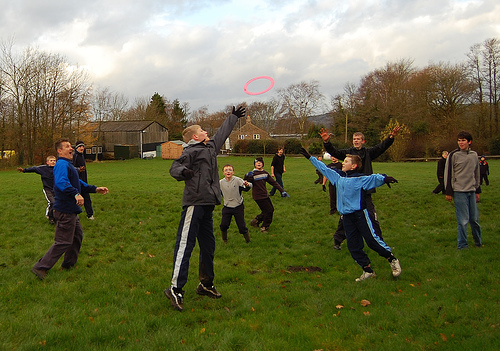

0.463828862571496
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
A woman and a man pose with Groucho Marx disguises .


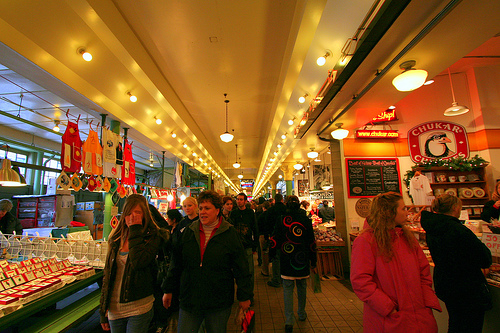

0.29338517388743474
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Two men standing near a metal structure in from of a brick wall .


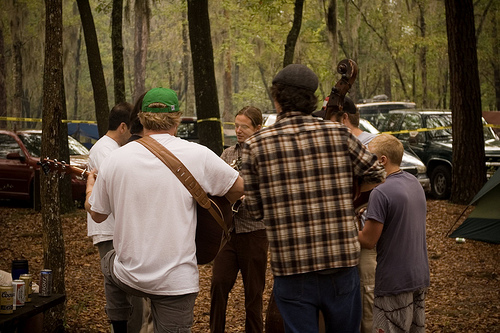

0.27891636359957267


In [102]:
search_img(df_sample)

### clip

In [105]:
clip_model = SentenceTransformer('clip-ViT-B-32')

In [106]:
### Получим список уникальных тестовых изображений
img_names = list(test_images.image.unique())

### Получим список путей к каждой картинке
img_names = list(map(lambda x: path+'test_images/'+x, img_names))
print("Images:", len(img_names))

Images: 100


In [107]:
img_emb = clip_model.encode([Image.open(filepath) for filepath in img_names], batch_size=1, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

In [108]:
df_sample

query_id  \
471   862156271_3eacea90a8.jpg#1   
472   862156271_3eacea90a8.jpg#2   
344  3455405300_aa3069ecaa.jpg#4   
170  2737233999_34d60dc5c3.jpg#0   
481   957682378_46c3b07bcd.jpg#1   
250  3163198309_bbfe504f0a.jpg#0   
454   607339469_af851c4119.jpg#4   
52   1991806812_065f747689.jpg#2   
259  3170110692_d1e0e66cee.jpg#4   
404  3601978895_9fec23ce0c.jpg#4   

                                            query_text  \
471                    two girls walking in the street   
472  Two girls walking next to each other and talki...   
344         Women wearing red and black are clapping .   
170                 Four children playing basketball .   
481  A brown dog is grabbing the collar of a black ...   
250  A skier coming over a snowy hill while people ...   
454                      Little girl feeds the ducks .   
52                      a kickboxer jumping for a kick   
259  A woman and a man pose with Groucho Marx disgu...   
404  Two men standing near a metal structure in fro...   

                         image  is_available  
471   862156271_3eacea90a8.jpg         False  
472   862156271_3eacea90a8.jpg         False  
344  3455405300_aa3069ecaa.jpg          True  
170  2737233999_34d60dc5c3.jpg         False  
481   957682378_46c3b07bcd.jpg          True  
250  3163198309_bbfe504f0a.jpg          True  
454   607339469_af851c4119.jpg         False  
52   1991806812_065f747689.jpg          True  
259  3170110692_d1e0e66cee.jpg          True  
404  3601978895_9fec23ce0c.jpg          True

In [109]:
def search_img(df_sample, pic_nums=1):

    ###  текст запросов и проверим на запрещенные слова. И удалим эти строки.
    df_sample['is_available'] = df_sample['query_text'].apply(find_exc_word)
    
    
    for i in df_sample.index.to_list():
        if df_sample.loc[i]['is_available'] == False:
            print(df_sample.loc[i]['query_text'])
            print('Запрос содержит запрещенные слова. \n')
            df_sample = df_sample.drop(i)
            
    ### Векторизируем оставщиеся запросы.        
    for i in range(0, df_sample.shape[0]):
        ### Выделяем запрос
#         query = test_queries.sample(1)['query_text'].values[0]
        query = df_sample['query_text'].values[i]
        
        ### Получаем эмбединг запроса
        query_emb = clip_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
        hits = util.semantic_search(query_emb, img_emb, top_k=pic_nums)[0]
        
        print(f'query: {query}')
        for hit in hits:
            print(f'score - {hit["score"]:.2}')
            best_img = Image.open(img_names[hit['corpus_id']]).convert('RGB')
            display(best_img)

two girls walking in the street
Запрос содержит запрещенные слова. 

Two girls walking next to each other and talking .
Запрос содержит запрещенные слова. 

Four children playing basketball .
Запрос содержит запрещенные слова. 

Little girl feeds the ducks .
Запрос содержит запрещенные слова. 

query: Women wearing red and black are clapping .
score - 0.32


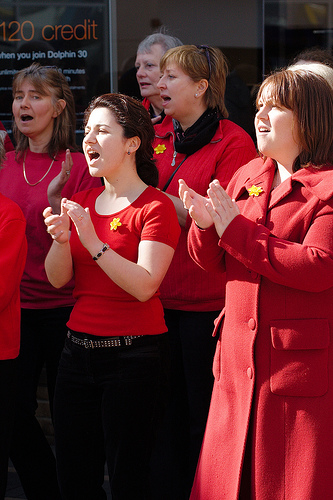

query: A brown dog is grabbing the collar of a black dog .
score - 0.33


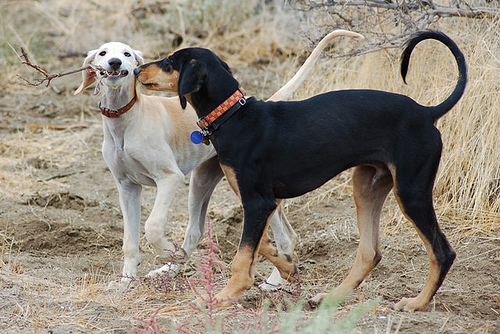

query: A skier coming over a snowy hill while people look on .
score - 0.31


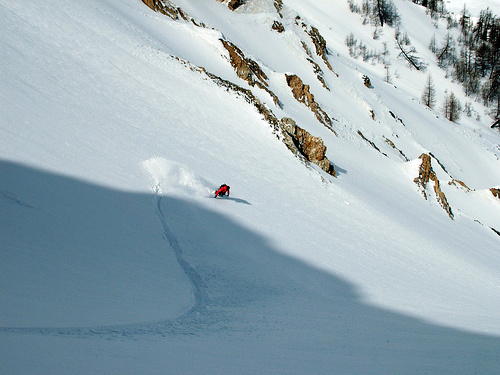

query: a kickboxer jumping for a kick
score - 0.32


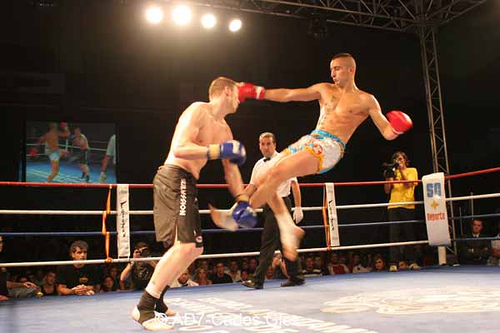

query: A woman and a man pose with Groucho Marx disguises .
score - 0.3


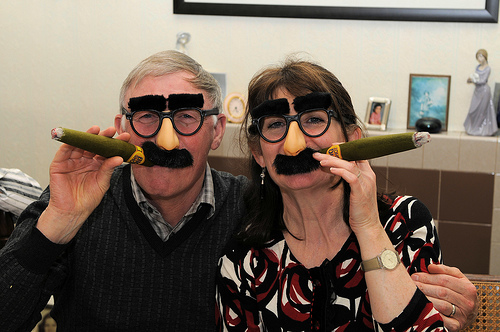

query: Two men standing near a metal structure in from of a brick wall .
score - 0.3


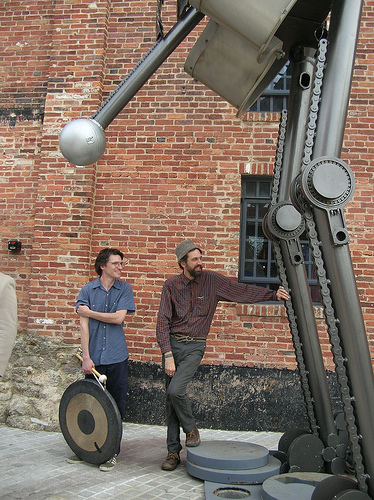

In [110]:
search_img(df_sample)

# **Выводы**

* Описание данных

В нашем основном датасете около 5800 строк. Пропусков в данных нет. В признаке "query_id" содержится идентификатор описания в формате <имя файла изображения>#<порядковый номер описания>. Заявлено, что к каждой картинке может быть до 5 описаний. Но все записи в датасете содержат только порядковый номер 2. Вероятнее всего в датасете представлена только часть данных. А вот в test_queries содержаться запросы с разными номерами. Поэтому мы не удалили номер запроса.

Обучающая выборка содержит 977 уникальных описаний и 1000 уникальных изображений.

В CrowdAnnotations содержится 47830 строк. Пропусков также нет. Столбец pos_share содержит информацию о доле людей, которые отметили пару картинка-описание как подходящие друг другу. Но стоит отметить, что в отличие от экспертов, обычные люди могли ставить только 1 или 0. Тогда как эксперты могли выставлять оценку соответствия по шкале от 1 до 4. Можно сказать, что разметка данных от экспертов более качественная. Возможно стоит использовать именно её для лучшего обучения модели. Также при объединении датафреймов CrowdAnnotations и ExpertAnnotations теряется очень много данных, в том числе с экспертной оценкой.

Выборка содердит разные по формату и тематике изображения людей и животных.

* Объединение датафреймов

Для решения задачи нам необходимо было выделить целевой признак. В нешем случае это степень соответствия описания и изображения. У нас есть две талицы с такой информацией: `CrowdAnnotations` и `ExpertAnnotations`.

В `CrowdAnnotations` содержится 47830 строк. Пропусков нет. Столбец pos_share содержит информацию о доле людей, которые отметили пару картинка-описание как подходящие друг другу. Но стоит отметить, что в отличие от экспертов, обычные люди могли ставить только 1 или 0. Тогда как эксперты в `ExpertAnnotations` могли выставлять оценку соответствия по шкале от 1 до 4. Можно сказать, что разметка данных от экспертов более качественная. 

Кажется, что в `CrowdAnnotations` много данных, однако при объединении с train_dataset мы теряем порядка 60% строк. Так как в `CrowdAnnotations` нет многих сочетаний картинка - описание из `train_dataset`, в котором содержится текст запроса. А соединение с сохранением всех строк `train_dataset` не имеет смысла, так как мы не получаем целевой признак для 60% строк.

Напротив, при объединении с `ExpertAnnotations` мы теряем ни одной строки и получаем более качественную разметку данных.

Мы объединили `ExpertAnnotations` и `train_dataset` не потеряв ни одной строки и получив достаточно качественную оценку от экспертов.

* Оценка экспертов

Мы получили наш целевой признак target

Объединим три оценки экспертов в одну. Поскольку в таблице есть оценки от трёх экспертов, написали функцию, которая обощила оценку: выбрала наиболее частую оценку (моду), а если такой нет нет, то вернула None.

Улаоиои строки, для которых не получили единой оценки. Потеряли 2.16 % строк, что допустимо.

Нормализовали полученную оценку. Модель должна выдавать результат от 0 до 1. Эксперты давали 4 оценки от 1 до 4, где 1 полное несоответсвие, а 4 полное соответсвие. Мы перевели это в доли, где 1 - 0, а 4 - 1 по формуле (x-1)/3.

* Проверка данных

Поскольку в некоторых странах действуют ограничения по обработке изображений, нам необходимо было исключить из датафрема все описания детей в возрасте до 16 лет. Мы составили составили словарь с запрещёнными словами. Написали функцию, которая проверяет описания и возвращает True если текст соответвует юридическим ограничениям, и False если не соответсвует.

Для проверки стоило бы лемматизировать текст, однако это достаточно долгая и затратная обработка данных. Поэтому для очистки данных от запрещённых слов мы просто добавили в словарь разные формы запрещенных слов. А для векторизации текстов воспользуемся предобученной моделью BERT, которая работает и с не лематизированным текстом.

Мы составили список запрещённых фото, описание которых содержит запрещенные слова. Таких фото оказалось 296. Мы удалили их из датафрейма потеряв 31.67 % строк.

* Векторизация изображений

Используя предобученную resnet18 мы получили вектора для каждого уникального изображения из обучающего датасета.

* Векторизация текстов

При помощи предобученной модели BERT мы получили вектора уникальных описаний и сохранили их в датафрейм df_unique_txt.

* Объединение векторов

Мы присоединили к нашему очищенному датафрейму с экспертной оценкой уникальные векторы соответсвующего изображения и описания. Размер полученного датафрейма 5631 строк × 1284 признаков.

* Обучение моделей

Мы получили бэйзлайн на базе DummyRegressor(strategy="median"). Можно использовать метрику бэйзлайна и метрики других моделей, для оценки их адекватности.

В качестве метрики выберем MAE, она измеряет разницу между предсказанными значениями и истинными значениями.

Также мы обучили модели линейной регрессии, LightGBM, ElasticNet, Catboost и нейронную сеть.

Лучшую метрику на валидационной выборке показала модель LightGBM.